In [9]:
# LIBRARY IMPORT
from __future__ import annotations

import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import (
    LinearDiscriminantAnalysis,
    QuadraticDiscriminantAnalysis,
)
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.neighbors import KNeighborsClassifier

sns.set()


## Partie 1: Analyse univariée des données

In [10]:
def load_df(
    path: str, reduce: bool = False, remove_timestamps: bool = False,
) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """Loads a dataset from an excel file into a Pandas Dataframe"""

    df = pd.read_excel(path, index_col=0)
    print(f"path shape: {df.shape[0]} rows, {df.shape[1]} cols")

    if df.isnull().values.any():
        print("Missing cell values found!")

    if reduce:
        numeric_data = df[["Temperature", "Humidity", "Light", "CO2", "HumidityRatio"]]
        numeric_data = (numeric_data - numeric_data.mean()) / numeric_data.std()
        df[["Temperature", "Humidity", "Light", "CO2", "HumidityRatio"]] = numeric_data

    if remove_timestamps:
        df.drop(["Time", "Date"], axis=1, inplace=True)

    targets = df.Occupancy
    target_names = df.Occupancy.unique()
    data = df.drop(["Occupancy"], axis=1)
    return data, targets, target_names


training_data, training_targets, training_targets_names = load_df(
    "datasets/datatraining.xlsx"
)
test_data, test_targets, test_targets_names = load_df("datasets/datatest.xlsx")
test2_data, test2_targets, test2_targets_names = load_df("datasets/datatest2.xlsx")

print("Columns of training_data:", training_data.columns.values)
display(training_data.describe())


path shape: 8143 rows, 8 cols
path shape: 2665 rows, 8 cols
path shape: 9752 rows, 8 cols
Columns of training_data: ['Date' 'Time' 'Temperature' 'Humidity' 'Light' 'CO2' 'HumidityRatio']


,Temperature,Humidity,Light,CO2,HumidityRatio
count,8143.000000,8143.000000,8143.000000,8143.000000,8143.000000
mean,20.619084,25.731507,119.519375,606.546243,0.003863
std,1.016916,5.531211,194.755805,314.320877,0.000852
min,19.000000,16.745000,0.000000,412.750000,0.002674
25%,19.700000,20.200000,0.000000,439.000000,0.003078
50%,20.390000,26.222500,0.000000,453.500000,0.003801
75%,21.390000,30.533333,256.375000,638.833333,0.004352
max,23.180000,39.117500,1546.333333,2028.500000,0.006476


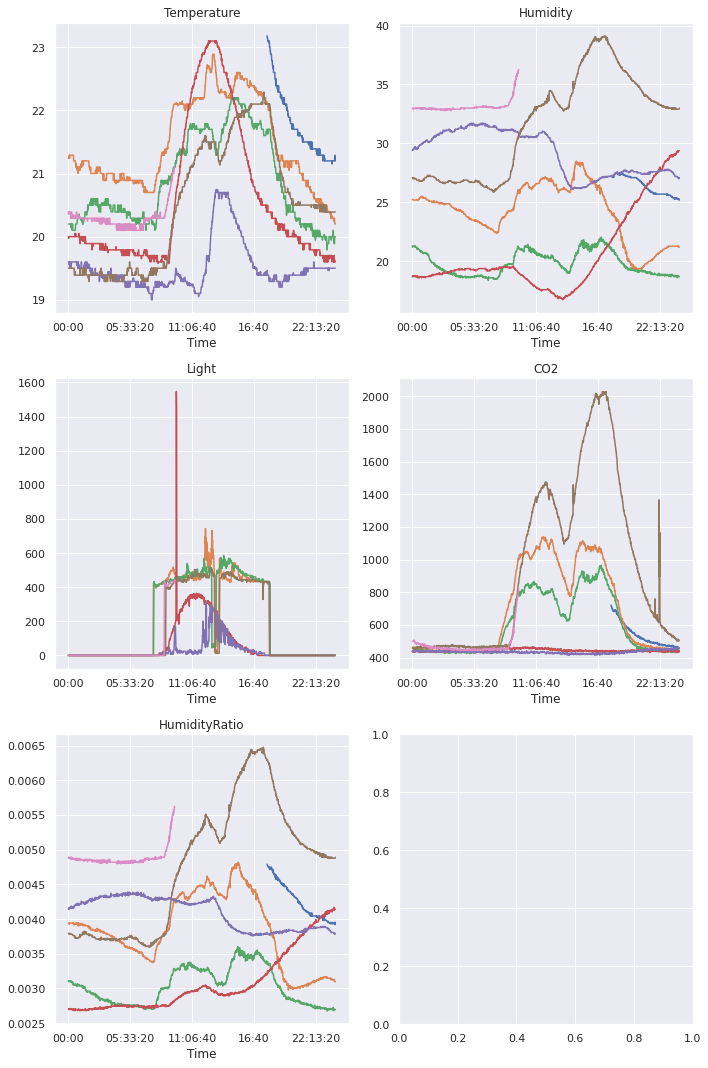

In [11]:
plt.rcParams["figure.figsize"] = [10, 15]
fig, axs = plt.subplots(3, 2)

for day in training_data["Date"].unique():
    day_data = training_data[training_data["Date"] == day].set_index("Time")

    for i, col in enumerate(training_data.columns[2:]):
        day_data[col].plot(ax=axs[i // 2, i % 2])
        axs[i // 2, i % 2].set_title(col)

    plt.tight_layout()


On veut maintenant les données centrées réduites sans les colonnes inutiles à la classification:

In [12]:
training_data, training_targets, training_targets_names = load_df(
    "datasets/datatraining.xlsx", reduce=True, remove_timestamps=True,
)
test_data, test_targets, test_targets_names = load_df(
    "datasets/datatest.xlsx", reduce=True, remove_timestamps=True,
)
test2_data, test2_targets, test2_targets_names = load_df(
    "datasets/datatest2.xlsx", reduce=True, remove_timestamps=True,
)


path shape: 8143 rows, 8 cols
path shape: 2665 rows, 8 cols
path shape: 9752 rows, 8 cols


## Partie 2: Analyse bivariée

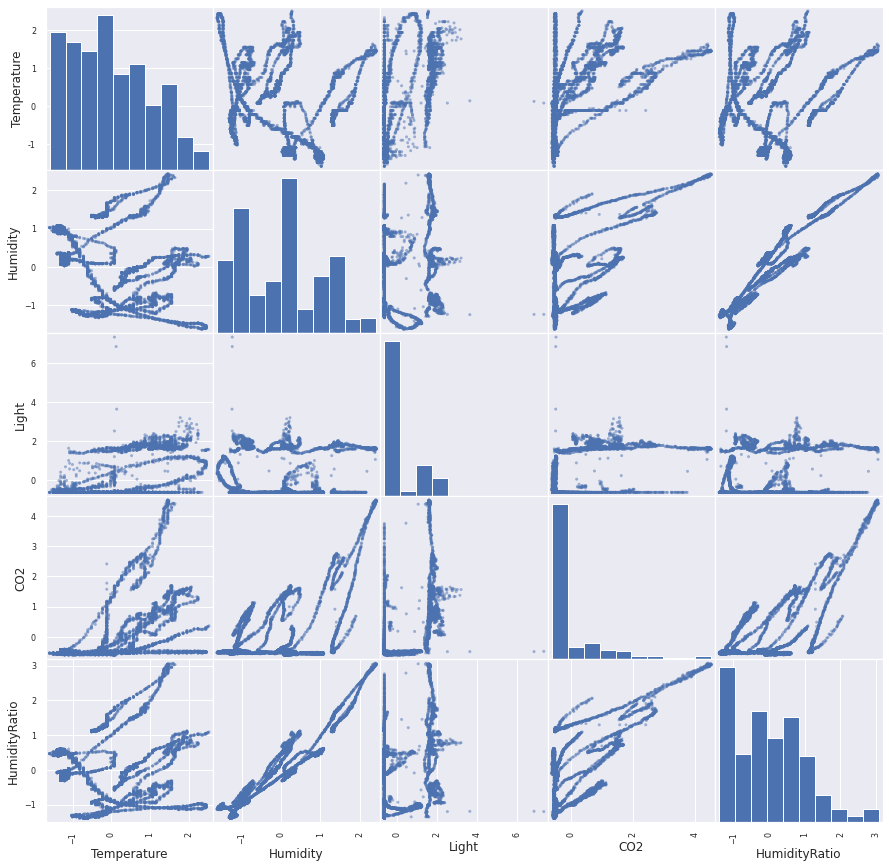

In [13]:
plt.rcParams["figure.figsize"] = [15, 15]
pd.plotting.scatter_matrix(training_data)
pass


## Partie 3: LDA

In [14]:
# Load data suitable for LDA
training_data, training_targets, training_targets_names = load_df(
    "datasets/datatraining.xlsx", remove_timestamps=True
)
test_data, test_targets, test_targets_names = load_df(
    "datasets/datatest.xlsx", remove_timestamps=True
)
test2_data, test2_targets, test2_targets_names = load_df(
    "datasets/datatest2.xlsx", remove_timestamps=True
)

# Fit data and train model
lda = LinearDiscriminantAnalysis()
lda.fit(training_data, training_targets)
transformed_test_data = lda.transform(test_data)


path shape: 8143 rows, 8 cols
path shape: 2665 rows, 8 cols
path shape: 9752 rows, 8 cols


Text(0, 0.5, 'Class')

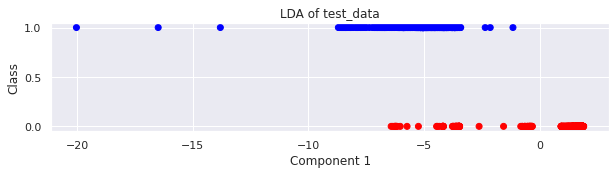

In [15]:
palette = ["red", "blue"]
colours = [palette[i] for i in test_targets]

plt.rcParams["figure.figsize"] = [10, 2]
plt.scatter(transformed_test_data, test_targets, c=colours)
plt.title("LDA of test_data")
plt.xlabel("Component 1")
plt.ylabel("Class")


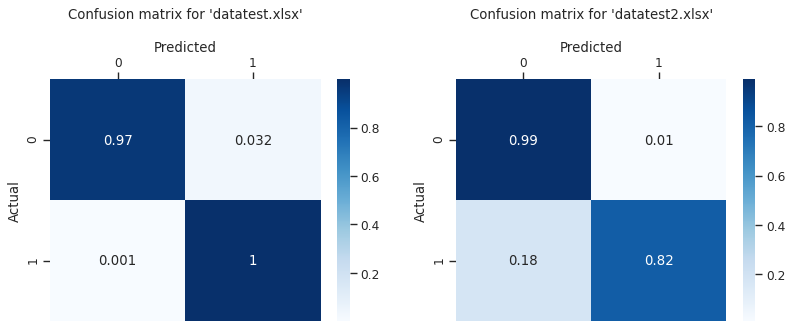

In [18]:
predicted_classes = lda.predict(test_data)

plt.figure(figsize=(12, 4), dpi=80)
ax = plt.subplot(1, 2, 1)

cm_normalized = confusion_matrix(test_targets, predicted_classes, normalize="true")
sns.heatmap(cm_normalized, annot=True, cmap="Blues")
plt.title(f"Confusion matrix for 'datatest.xlsx'", pad=20)
plt.ylabel(f"Actual")
plt.xlabel(f"Predicted")
ax.xaxis.set_label_position("top")
ax.xaxis.tick_top()
ax.yaxis.tick_left()

transformed_test2_data = lda.transform(test2_data)
predicted_classes2 = lda.predict(test2_data)

ax = plt.subplot(1, 2, 2)
cm2_normalized = confusion_matrix(test2_targets, predicted_classes2, normalize="true")
sns.heatmap(cm2_normalized, annot=True, cmap="Blues")
plt.title(f"Confusion matrix for 'datatest2.xlsx'", pad=20)
plt.ylabel(f"Actual")
plt.xlabel(f"Predicted")
ax.xaxis.set_label_position("top")
ax.xaxis.tick_top()
ax.yaxis.tick_left()


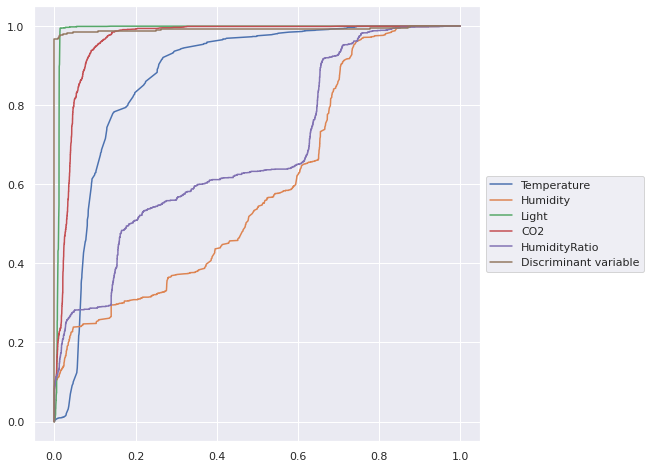

In [19]:
plt.rcParams["figure.figsize"] = [8, 8]

for col in training_data.columns:
    FP, TP, Th = roc_curve(training_targets, training_data[col], pos_label=1)
    plt.plot(FP, TP, label=col)

FP, TP, Th = roc_curve(test_targets, transformed_test_data, pos_label=1)
plt.plot(TP, FP, label="Discriminant variable")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))


Optimal threshold: -3.5173996247128616


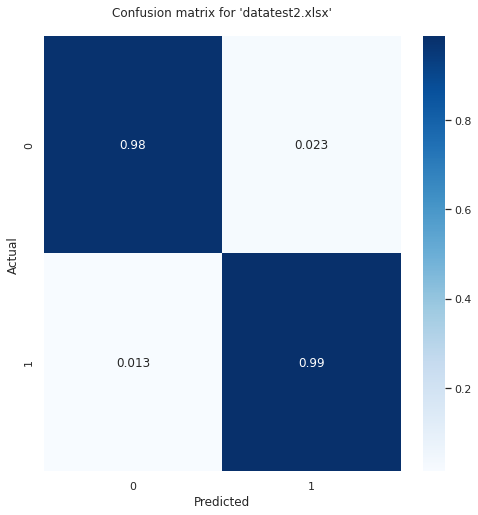

In [20]:
def Find_Optimal_Cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------     
    list type, with optimal cutoff value
        
    src: https://stackoverflow.com/a/32482924
    """
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr))
    roc = pd.DataFrame(
        {
            "tf": pd.Series(tpr - (1 - fpr), index=i),
            "threshold": pd.Series(threshold, index=i),
        }
    )
    roc_t = roc.iloc[(roc.tf - 0).abs().argsort()[:1]]

    return list(roc_t["threshold"])


def find_optimal_threshold(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate"""

    # calculate roc curve
    probas_false_pos, probas_true_pos, threshold = roc_curve(target, predicted)
    
    # optimal point is closest to top left corner of the 1x1 graph:
    top_left = (0, 1)
    point_coords = [
        (p_true_pos, p_false_pos)
        for p_false_pos, p_true_pos in zip(probas_false_pos, probas_true_pos)
    ]

    # calculate euclidian distances between each point and the top left corner
    distances = []
    for i, point in enumerate(point_coords):
        distances.append((
            i,
            math.sqrt((top_left[0] - point[0]) ** 2 + (top_left[1] - point[1]) ** 2),
        ))

    # find the closest one and return it
    optimal_point = min(distances, key=lambda x: x[1])
    return threshold[optimal_point[0]]


threshold = find_optimal_threshold(test_targets, transformed_test_data)
print(f"Optimal threshold: {threshold}")

# Apply prediction to the dataframe applying threshold
transformed_test_data_mapped = (transformed_test_data < threshold).astype(int)

# Print confusion Matrix
cm3_normalized = confusion_matrix(
    test_targets, transformed_test_data_mapped, normalize="true"
)
sns.heatmap(cm3_normalized, annot=True, cmap="Blues")
plt.title(f"Confusion matrix for 'datatest2.xlsx'", pad=20)
plt.ylabel(f"Actual")
plt.xlabel(f"Predicted")
ax.xaxis.set_label_position("top")
ax.xaxis.tick_top()
ax.yaxis.tick_left()

## Partie 4: K plus proches voisins

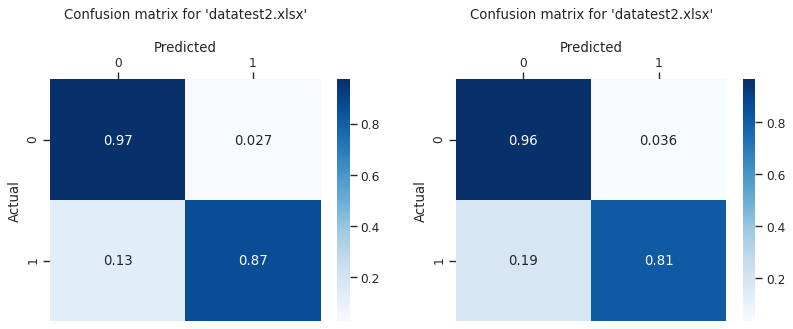

In [21]:
k = 3
model = KNeighborsClassifier(n_neighbors=k)
model.fit(training_data, training_targets)


plt.figure(figsize=(12, 4), dpi=80)
ax = plt.subplot(1, 2, 1)

test_data_predicted = model.predict(test_data)

cm_normalized = confusion_matrix(test_targets, test_data_predicted, normalize="true")
sns.heatmap(cm_normalized, annot=True, cmap="Blues")
plt.title(f"Confusion matrix for 'datatest2.xlsx'", pad=20)
plt.ylabel(f"Actual")
plt.xlabel(f"Predicted")
ax.xaxis.set_label_position("top")
ax.xaxis.tick_top()
ax.yaxis.tick_left()
test_data_predicted = model.predict(test_data)

ax = plt.subplot(1, 2, 2)

test2_data_predicted = model.predict(test2_data)

cm_normalized = confusion_matrix(test2_targets, test2_data_predicted, normalize="true")
sns.heatmap(cm_normalized, annot=True, cmap="Blues")
plt.title(f"Confusion matrix for 'datatest2.xlsx'", pad=20)
plt.ylabel(f"Actual")
plt.xlabel(f"Predicted")
ax.xaxis.set_label_position("top")
ax.xaxis.tick_top()
ax.yaxis.tick_left()


## Partie 5: QDA

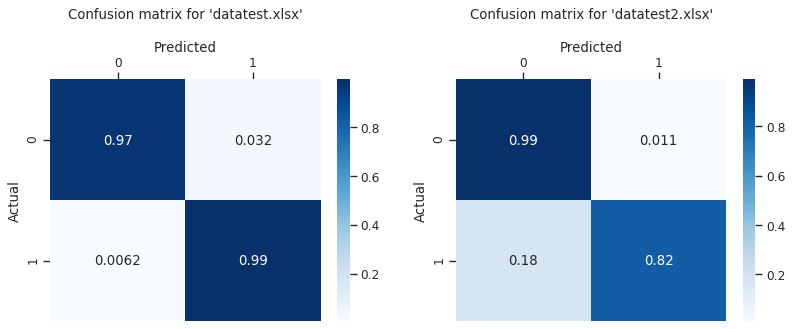

In [22]:
# Fit data and train model
qda = QuadraticDiscriminantAnalysis()
qda.fit(training_data, training_targets)
predicted_classes = qda.predict(test_data)

plt.figure(figsize=(12, 4), dpi=80)
ax = plt.subplot(1, 2, 1)

cm_normalized = confusion_matrix(test_targets, predicted_classes, normalize="true")
sns.heatmap(cm_normalized, annot=True, cmap="Blues")
plt.title(f"Confusion matrix for 'datatest.xlsx'", pad=20)
plt.ylabel(f"Actual")
plt.xlabel(f"Predicted")
ax.xaxis.set_label_position("top")
ax.xaxis.tick_top()
ax.yaxis.tick_left()

predicted_classes2 = qda.predict(test2_data)

ax = plt.subplot(1, 2, 2)
cm2_normalized = confusion_matrix(test2_targets, predicted_classes2, normalize="true")
sns.heatmap(cm2_normalized, annot=True, cmap="Blues")
plt.title(f"Confusion matrix for 'datatest2.xlsx'", pad=20)
plt.ylabel(f"Actual")
plt.xlabel(f"Predicted")
ax.xaxis.set_label_position("top")
ax.xaxis.tick_top()
ax.yaxis.tick_left()


## Partie 6: les 20% de faux négatifs

On voit que les faux négatifs (points verts) correspondent à des moments où quelqu'un est dans la pièce mais que la lumière est faible ainsi que le taux de CO2

=> Lumières éteintes et fenêtres ouvertes?

path shape: 9752 rows, 8 cols


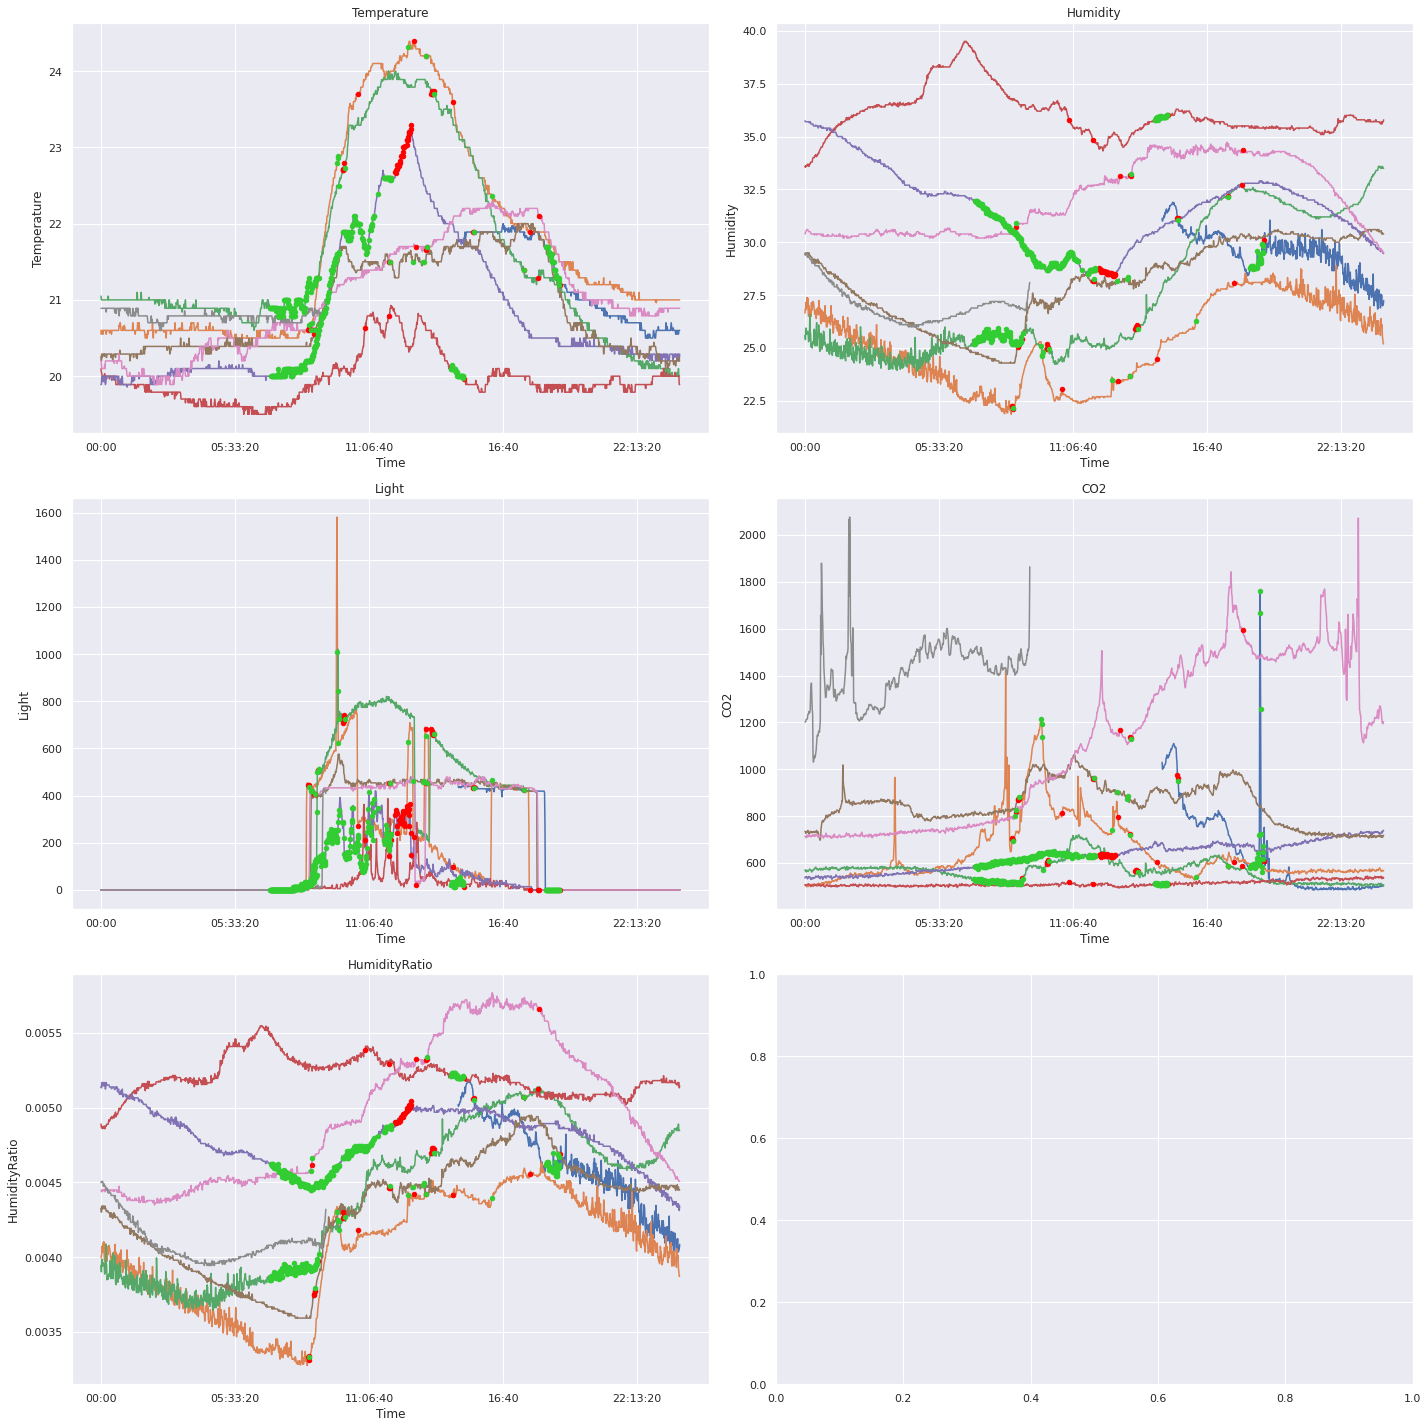

In [68]:
comparison = pd.DataFrame({"Target": test2_targets, "Predicted": predicted_classes2})
mistakes = comparison[comparison.Target != comparison.Predicted].index

full_test2_data, full_test2_targets, full_test2_targets_names = load_df("datasets/datatest2.xlsx")

error_tarerror_targetsgets = full_test2_targets.iloc[mistakes]
fneg_indices = error_targets[error_targets == 1].index
fpos_indices = error_targets[error_targets == 0].index


fnegs = full_test2_data.iloc[fneg_indices, :]
fposes = full_test2_data.iloc[fpos_indices, :]

plt.rcParams["figure.figsize"] = [20, 20]
fig, axs = plt.subplots(3, 2)

# Plot all data
for day in full_test2_data["Date"].unique():
    day_data = full_test2_data[full_test2_data["Date"] == day].set_index("Time")
    fneg_data = fnegs[fnegs["Date"] == day]
    fpos_data = fposes[fposes["Date"] == day]

    for i, col in enumerate(full_test2_data.columns[2:]):
        day_data[col].plot(ax=axs[i // 2, i % 2])
        fneg_data.plot.scatter(x="Time", y=col, ax=axs[i // 2, i % 2], color='limegreen', zorder=100)
        fpos_data.plot.scatter(x="Time", y=col, ax=axs[i // 2, i % 2], color='red', zorder=99)
        axs[i // 2, i % 2].set_title(col)

    plt.tight_layout()